In [1]:
# Import data science libraries
import pandas as pd
from math import radians
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
# Sci-kit Learn packages
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

In [3]:
# Read data into pandas and check features
data_file = "data/WUG_SMO_Data_Clean.csv"
wind_df = pd.read_csv(data_file)
wind_df.columns

Index(['Unnamed: 0', 'date', 'fog', 'rain', 'meanwdird', 'meanwindspdm',
       'meantempm', 'meandewptm', 'meanpressurem', 'maxhumidity',
       'minhumidity', 'maxtempm', 'mintempm', 'maxdewptm', 'mindewptm',
       'maxpressurem', 'minpressurem', 'precipm', 'year', 'month', 'day',
       'dayofweek'],
      dtype='object')

In [4]:
# Let's drop min/max and just stick with mean values for now
wind_df = wind_df.drop(['date', 'rain', 'maxhumidity', 'minhumidity', 'maxtempm', 
                        'mintempm', 'maxdewptm', 'mindewptm', 'maxpressurem', 
                        'minpressurem', 'year', 'month', 'day', 'dayofweek', 'Unnamed: 0'], 
                       axis=1)

In [5]:
wind_df.head(3)

,fog,meanwdird,meanwindspdm,meantempm,meandewptm,meanpressurem,precipm
0,0,236,3.0,18.0,14.0,1020.0,0.0
1,1,207,5.0,16.0,16.0,1017.0,0.0
2,1,251,14.0,17.0,11.0,1015.0,0.0


In [6]:
# Rename columns for ease
wind_df.columns = ['fog', 'mdir', 'mspd', 'mtmp', 'mdew', 'mpressure', 'precipm']

# Check for null values
wind_df.isnull().sum()

fog           0
mdir          0
mspd         33
mtmp         61
mdew         61
mpressure    37
precipm       0
dtype: int64

In [7]:
# Drop any rows with missing values
wind_df = wind_df.dropna()

# Check head of df
wind_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5408 entries, 0 to 5477
Data columns (total 7 columns):
fog          5408 non-null int64
mdir         5408 non-null int64
mspd         5408 non-null float64
mtmp         5408 non-null float64
mdew         5408 non-null float64
mpressure    5408 non-null float64
precipm      5408 non-null float64
dtypes: float64(5), int64(2)
memory usage: 338.0 KB


### About the data

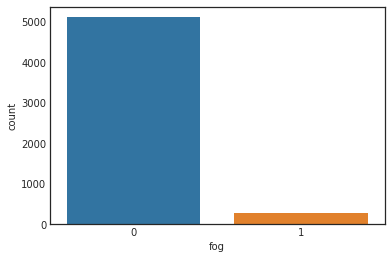

In [8]:
sns.set_style('white')

# Check number of foggy days
sns.countplot(x='fog', data=wind_df)

In [9]:
# Descriptive statistics
wind_df.describe()

,fog,mdir,mspd,mtmp,mdew,mpressure,precipm
count,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000,5408.000000
mean,0.053070,206.825999,7.249075,17.007027,10.142197,1015.233615,0.599135
std,0.224193,73.475321,3.701791,3.569535,5.596071,3.825172,3.916247
min,0.000000,-1.000000,2.000000,6.000000,-19.000000,990.000000,0.000000
25%,0.000000,204.000000,5.000000,14.000000,8.000000,1013.000000,0.000000
50%,0.000000,224.000000,6.000000,17.000000,11.000000,1015.000000,0.000000
75%,0.000000,236.000000,10.000000,19.000000,14.000000,1017.000000,0.000000
max,1.000000,360.000000,50.000000,30.000000,21.000000,1031.000000,74.170000


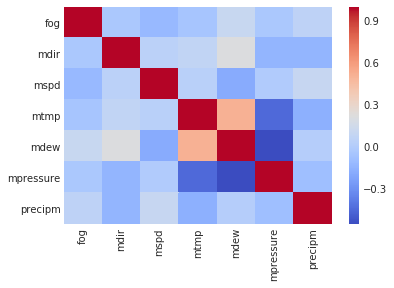

In [10]:
# Check for correlation between features
sns.heatmap(wind_df.corr(), cmap='coolwarm')

Text(0.5,1,'Distribution of Mean Wind Bearing')

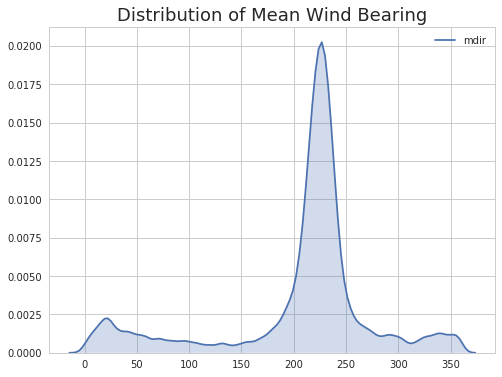

In [11]:
# We can clearly see the prevailing winds coming from a SW direction (from the ocean)
# There's also a couple interesting bumps coming from the East - the Santa Ana Winds
sns.set(style='whitegrid')
plt.figure(figsize=(8,6))

sns.kdeplot(wind_df['mdir'], shade=True)

plt.title("Distribution of Mean Wind Bearing", fontsize=18)

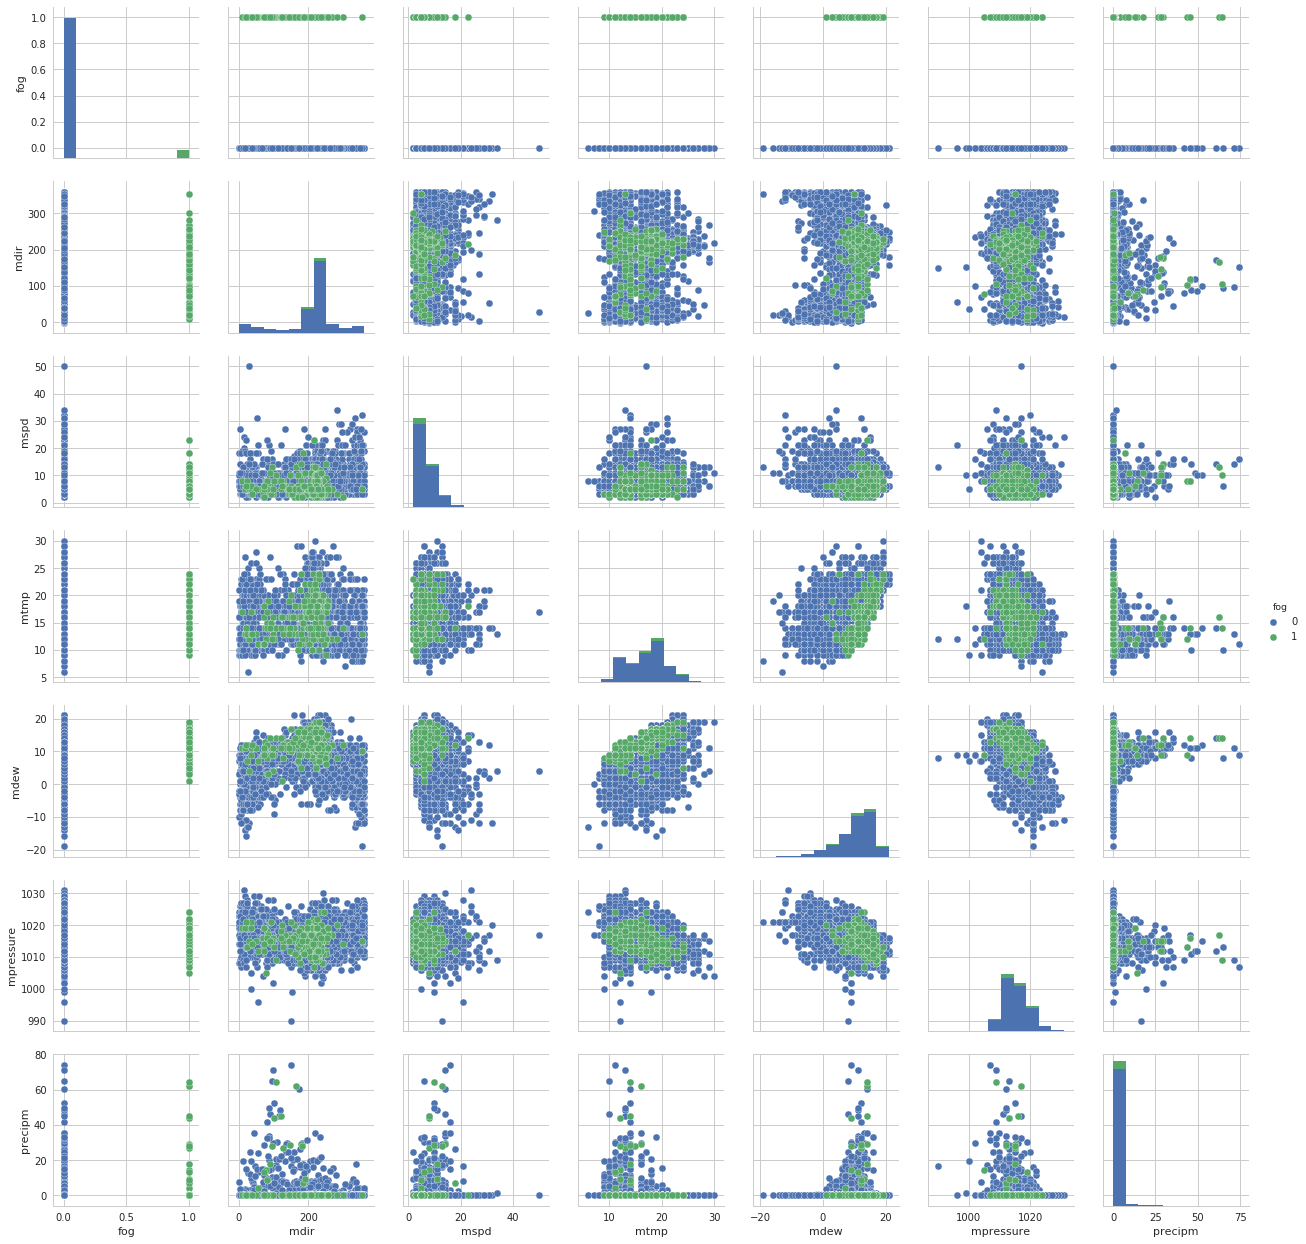

In [12]:
# Let's look at how features relate to each other based on whether or not there was fog
sns.pairplot(wind_df, 'fog')

In [13]:
# Combine these next 'target' graphs in a grid and maybe simplify with vectors

Text(0.5,1.05,'Mean Wind Bearing (°) vs Mean Windspeed (km/h)')

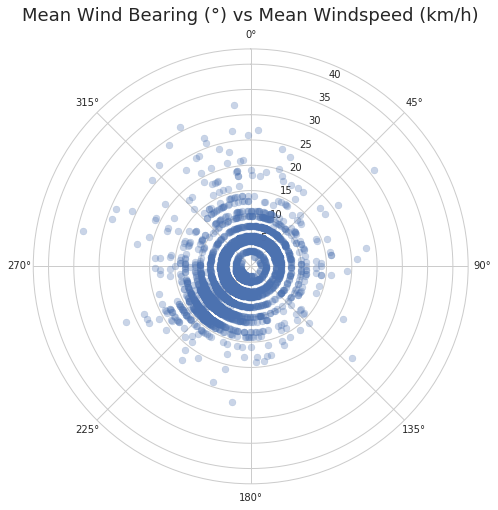

In [14]:
plt.figure(figsize=(8,8))

ax = plt.subplot(111, polar=True)
ax.scatter(x=[radians(x) for x in wind_df['mdir'].values], 
           y=wind_df['mspd'], alpha=0.3)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

plt.title('Mean Wind Bearing (°) vs Mean Windspeed (km/h)', fontsize=18)

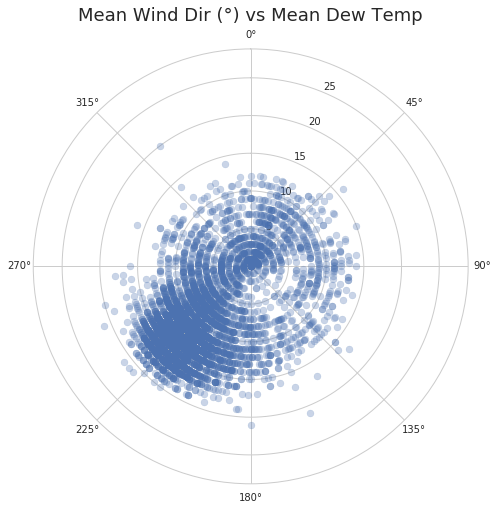

In [15]:
sns.set(style='whitegrid')
plt.figure(figsize=(8,8))

ax = plt.subplot(111, polar=True)
ax.scatter(x=[radians(x) for x in wind_df['mdir'].values], 
           y=wind_df['mdew'], alpha=0.3)
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

plt.title('Mean Wind Dir (°) vs Mean Dew Temp', fontsize=18);

In [16]:
# Cool but realign x-grid to clearly show dual bumps, plus color fog hue

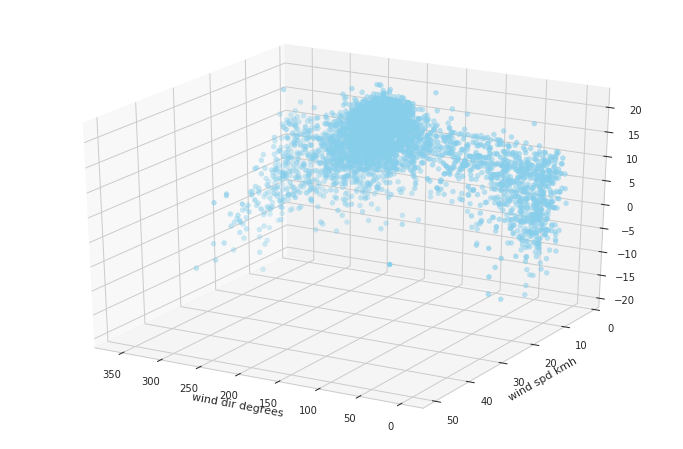

In [17]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(wind_df['mdir'], wind_df['mspd'], wind_df['mdew'], c='skyblue', s=25)
plt.xlabel('wind dir degrees')
plt.ylabel('wind spd kmh')
plt.clabel('dewpoint degrees C')
ax.view_init(25, 120)
plt.show()

### Data preprocessing

Split data into training and test sets

In [18]:
X = wind_df[['mdir', 'mspd', 'mtmp', 'mdew', 'mpressure', 'precipm']]
y = wind_df['fog']

X[:2]

,mdir,mspd,mtmp,mdew,mpressure,precipm
0,236,3.0,18.0,14.0,1020.0,0.0
1,207,5.0,16.0,16.0,1017.0,0.0


In [19]:
# Standardize scale for model comparison
sc = StandardScaler()
X = sc.fit_transform(X)

In [20]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

### Modeling

In [21]:
# Try decision tree classifer
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
dtree.score(X_test, y_test)

0.91250770178681451

In [22]:
# Run the gamute of classifiers available in scikit-learn to assess accuracy
models = [LogisticRegression(), 
          LinearSVC(), 
          SVC(kernel='rbf'), 
          KNeighborsClassifier(), 
          RandomForestClassifier(), 
          DecisionTreeClassifier(), 
          GradientBoostingClassifier(), 
          GaussianNB()]

model_names = ['Logistic Regression', 
               'Linear SVM', 
               'rbf SVM', 
               'K-Nearest Neighbors', 
               'Random Forest Classifier', 
               'Decision Tree', 
               'Gradient Boosting Classifier', 
               'Gaussian NB']

acc = []
m = {}

for model in range(len(models)):
    clf = models[model]
    clf.fit(X_train, y_train)
    pred = clf.predict(X_test)
    acc.append(accuracy_score(pred, y_test))

m = {'Algorithm':model_names, 'Accuracy':acc}

In [23]:
acc_frame = pd.DataFrame(m)
acc_frame = acc_frame.set_index('Accuracy').sort_index(ascending=False)
acc_frame

,Algorithm
Accuracy,
0.950709,Logistic Regression
0.950709,Linear SVM
0.950709,rbf SVM
0.949476,K-Nearest Neighbors
0.948860,Random Forest Classifier
0.948860,Gradient Boosting Classifier
0.943931,Gaussian NB
0.911892,Decision Tree


### Logistic Regression

Instantiate model and fit data

In [24]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Predict values and evaluate from test set

In [25]:
pred = logmodel.predict(X_test)

In [26]:
print(classification_report(y_test, pred))

             precision    recall  f1-score   support

          0       0.95      1.00      0.97      1543
          1       0.00      0.00      0.00        80

avg / total       0.90      0.95      0.93      1623



/home/samco/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
